In [41]:
import pennylane as qml
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import tensorflow
import torch
import torch.nn as nn
from torch.autograd import Variable

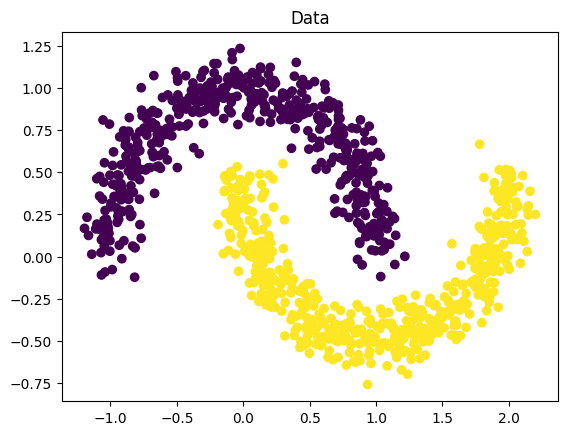

In [42]:
from sklearn.datasets import make_moons
from sklearn.datasets import make_gaussian_quantiles
from sklearn.datasets import make_classification

# DATA

sample_size = 1000
X, Y = make_moons(n_samples=sample_size, noise=0.1, random_state=100)

x = torch.from_numpy(X.astype(np.float32))
y = torch.from_numpy(Y.astype(np.float32)).view(-1,1)

plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='viridis')
plt.title("Data")
plt.show()
Data_type_1_X = []
Data_type_1_Y = []
Data_type_2_X = []
Data_type_2_Y = []

for i in range(0,len(Y -1)):
    if Y[i] == 1:
        Data_type_1_X.append( X[i][0])
        Data_type_1_Y.append( X[i][1])
    elif Y[i] == 0:
        Data_type_2_X.append( X[i][0])
        Data_type_2_Y.append( X[i][1])

In [43]:
# ANGLE EMBEDDING

qubits = 4
depth = 2
dev = qml.device("lightning.qubit", wires=qubits)

def angle_embedding(inputs):
  for i in range(qubits):
    qml.Hadamard(wires=i)

  for i in range(qubits):
    qml.RY(inputs[2*i], wires = i)
    qml.RZ(inputs[2*i + 1], wires = i)

embedding = angle_embedding

# CIRCUIT
@qml.qnode(dev, interface='torch')
def qnode(inputs, weights):

  embedding(inputs)

  for i in range(depth):
      for j in range(qubits):
            qml.RY(weights[2*(i*qubits + j) ], wires=j)
            qml.RZ(weights[2*(i*qubits + j) + 1], wires=j)
      for l in range(qubits):
            if (l == (qubits - 1)):
                qml.CNOT(wires=[l,0])
            else:
                qml.CNOT(wires=[l,l+1])

  for k in range(qubits):
        qml.RY(weights[(2*depth * qubits) + k ], wires=k)
        qml.RZ(weights[(2*depth * qubits) + k + 1], wires=k)

    # Measurement
  return [qml.expval(qml.PauliZ(wires=i)) for i in range(qubits)]

In [44]:
n_args =  2*(depth +1) * qubits
weight_shapes = {"weights": n_args}
print(qml.draw(qnode)(inputs = np.random.rand(qubits * 2), weights = np.random.rand(n_args)))

0: ──H──RY(0.90)──RZ(0.62)──RY(0.46)──RZ(0.60)─╭●───────╭X──RY(0.28)──RZ(0.55)─╭●───────╭X──RY(0.48)
1: ──H──RY(0.90)──RZ(0.69)──RY(0.23)──RZ(0.21)─╰X─╭●────│───RY(0.15)──RZ(0.99)─╰X─╭●────│───RY(0.91)
2: ──H──RY(0.41)──RZ(0.51)──RY(0.77)──RZ(0.82)────╰X─╭●─│───RY(0.36)──RZ(0.14)────╰X─╭●─│───RY(0.84)
3: ──H──RY(0.64)──RZ(0.94)──RY(0.47)──RZ(0.91)───────╰X─╰●──RY(0.17)──RZ(0.66)───────╰X─╰●──RY(0.71)

───RZ(0.91)─┤  <Z>
───RZ(0.84)─┤  <Z>
───RZ(0.71)─┤  <Z>
───RZ(0.12)─┤  <Z>


In [45]:
class QNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 8)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.qlayer_1 = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.relu2 = nn.ReLU()
        self.out = nn.Linear(4, 1)
        self.out_act = nn.Sigmoid()

    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.qlayer_1(torch.detach(dout[0]))
        h2 = self.relu2(a2.unsqueeze(0))
        a3 = self.out(h2)
        y = self.out_act(a3)
        return y

qnet = QNet()

In [46]:
def train_epoch(model, opt, criterion, X, Y):
    model.train()
    losses = []
    for beg_i in range(0, X.size(0)):
        x_batch = X[beg_i:beg_i + 1, :]
        y_batch = Y[beg_i:beg_i + 1, :]
        x_batch = Variable(x_batch)
        y_batch = Variable(y_batch)
        
        opt.zero_grad()
        y_hat = model(x_batch)
        loss = criterion(y_hat, y_batch)
        loss.backward()
        opt.step()
        losses.append(loss.item())
    return losses

In [47]:
# Define Optimizer and loss function
q_opt = torch.optim.Adam(qnet.parameters(), lr=0.002, betas=(0.9, 0.999))
criterion = nn.BCELoss()

In [48]:
e_losses_q1 = []
num_epochs = 10


for e in range(num_epochs):
    e_losses_q1 += train_epoch(qnet, q_opt, criterion, x, y)

test_pred_q1 = torch.empty((sample_size,1))
for i in range(0, x.size(0)):
    x_temp = x[i:i + 1, :]
    test_pred_q1[i] = torch.round(qnet(x_temp))

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc


Angle_embedding_result = f"{accuracy_fn(y, test_pred_q1):.1f}"



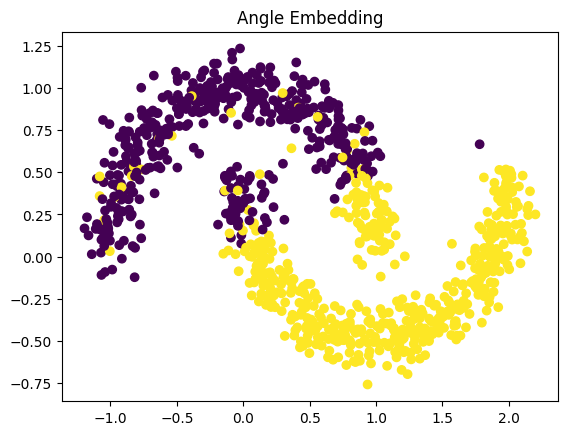

In [49]:
plt.scatter(X[:, 0], X[:, 1], c=test_pred_q1[:, 0].detach().numpy(), cmap='viridis')
plt.title("Angle Embedding")

Angle_embedding_points_for_1_coordinate_X = []
Angle_embedding_points_for_1_coordinate_Y = []
Angle_embedding_points_for_2_coordinate_X = []
Angle_embedding_points_for_2_coordinate_Y = []

a1 = test_pred_q1[:, 0].detach().numpy()
for i in range(0,len(a1 -1)):
    if a1[i] == 1:
        Angle_embedding_points_for_1_coordinate_X.append( X[i][0])
        Angle_embedding_points_for_1_coordinate_Y.append( X[i][1])
    elif a1[i] == 0:
        Angle_embedding_points_for_2_coordinate_X.append( X[i][0])
        Angle_embedding_points_for_2_coordinate_Y.append( X[i][1])


In [50]:
# AMPLITUDE AND BASIS EMBEDDING

def amplitude_embedding(data):
  # state = qml.templates.AmplitudeEmbedding(features=data, wires=range(qubits), pad_with=0.0, normalize=True)
  state = 1/(1+np.exp(-data))
  state = state/np.sqrt(sum(state**2))
  qml.StatePrep(state, wires=range(3))

def basis_embedding(inputs):
    binary_inputs = (inputs >= 0.5).to(torch.int)
    for i in range(qubits):
        if binary_inputs[i] == 1:
            qml.PauliX(wires=i)



In [51]:
#AMPLITUDE
embedding = amplitude_embedding

#CIRCUIT
print(qml.draw(qnode)(inputs = np.random.rand(qubits * 2), weights = np.random.rand(n_args)))
# [np.random.choice([0, 1]) for _ in range(qubits)]
# np.random.rand(qubits * 2)

0: ─╭|Ψ⟩───────RY(0.28)──RZ(0.59)─╭●───────╭X──RY(0.22)──RZ(0.90)─╭●───────╭X──RY(0.88)──RZ(0.71)─┤
1: ─├|Ψ⟩───────RY(0.01)──RZ(0.24)─╰X─╭●────│───RY(0.15)──RZ(0.76)─╰X─╭●────│───RY(0.71)──RZ(0.45)─┤
2: ─╰|Ψ⟩───────RY(0.98)──RZ(0.20)────╰X─╭●─│───RY(0.97)──RZ(0.94)────╰X─╭●─│───RY(0.45)──RZ(0.73)─┤
3: ──RY(0.79)──RZ(0.94)─────────────────╰X─╰●──RY(0.47)──RZ(0.89)───────╰X─╰●──RY(0.73)──RZ(0.45)─┤

   <Z>
   <Z>
   <Z>
   <Z>


In [52]:
class QNet_For_Amplitude_and_Basis(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 8)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(8, 4)  # New layer to map features to size 4
        self.qlayer_1 = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.relu2 = nn.ReLU()
        self.out = nn.Linear(4, 1)
        self.out_act = nn.Sigmoid()

    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.fc2(dout)  # Map features to size 4
        a2 = a2.squeeze(0)
        # Binarize the tensor (values >= 0 become 1, others become 0)
        a2_binarized = (a2 >= 0).float()

        q_out = self.qlayer_1(a2_binarized)
        h2 = self.relu2(q_out)
        a3 = self.out(h2)
        y = self.out_act(a3)
        return y
    
qnet_for_amplitude_and_basis = QNet_For_Amplitude_and_Basis()

In [53]:
def train_epoch_for_amplitude_and_basis(model, opt, criterion, X, Y):
    model.train()
    losses = []
    for beg_i in range(0, X.size(0)):
        x_batch = X[beg_i:beg_i + 1, :]
        y_batch = Y[beg_i:beg_i + 1, :]
        print(x_batch)

        x_batch = Variable(x_batch)
        y_batch = Variable(y_batch)
        
        opt.zero_grad()
        
        y_hat = model(x_batch)
        # Reshape y_hat to match the dimensions of y_batch
        y_hat = y_hat.view(-1, 1)
        loss = criterion(y_hat, y_batch)
        loss.backward()
        opt.step()
        
        losses.append(loss.item())
    return losses

In [54]:
embedding = amplitude_embedding

e_losses_q2 = []
for e in range(num_epochs):
    e_losses_q2 += train_epoch_for_amplitude_and_basis(qnet, q_opt, criterion, x, y)

test_pred_q2 = torch.empty((sample_size,1))
for i in range(0, x.size(0)):
    x_temp = x[i:i + 1, :]
    test_pred_q2[i] = torch.round(qnet(x_temp))


tensor([[0.0016, 1.0364]])
tensor([[-0.3312,  0.6102]])
tensor([[0.0256, 0.3386]])
tensor([[-0.8053,  0.5464]])
tensor([[0.1050, 0.0709]])
tensor([[0.7544, 0.7254]])
tensor([[-0.8141,  0.0520]])
tensor([[0.0357, 0.2767]])
tensor([[1.8886, 0.3896]])
tensor([[ 1.9600, -0.0168]])
tensor([[ 0.2405, -0.3002]])
tensor([[ 1.1994, -0.4904]])
tensor([[0.6833, 0.7092]])
tensor([[ 0.6083, -0.3075]])
tensor([[ 0.8366, -0.4367]])
tensor([[-0.8879,  0.6606]])
tensor([[-0.4949,  1.0604]])
tensor([[ 2.0874, -0.0396]])
tensor([[-0.2498,  0.9046]])
tensor([[ 0.4272, -0.2047]])
tensor([[2.0872, 0.1222]])
tensor([[0.3174, 0.8503]])
tensor([[1.8539, 0.0615]])
tensor([[1.1389, 0.2258]])
tensor([[0.8138, 0.5260]])
tensor([[ 0.3909, -0.3552]])
tensor([[ 1.5374, -0.1743]])
tensor([[1.0830, 0.1655]])
tensor([[0.0776, 0.1849]])
tensor([[ 1.2629, -0.3171]])
tensor([[2.1136, 0.0909]])
tensor([[0.4940, 0.8559]])
tensor([[0.2577, 0.9093]])
tensor([[-0.2686,  0.9449]])
tensor([[-0.2992,  0.7896]])
tensor([[ 1.0090, -

[6.4 4.8]


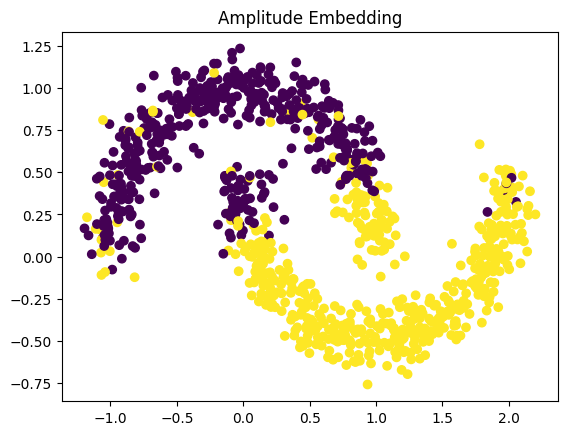

In [55]:

fig, ax1 = plt.subplots()

plt.scatter(X[:, 0], X[:, 1], c=test_pred_q2[:, 0].detach().numpy(), cmap='viridis')
plt.title("Amplitude Embedding")
print(fig.get_size_inches())
Amplitude_embedding_points_for_1_coordinate_X = []
Amplitude_embedding_points_for_1_coordinate_Y = []
Amplitude_embedding_points_for_2_coordinate_X = []
Amplitude_embedding_points_for_2_coordinate_Y = []

temp = test_pred_q2[:, 0].detach().numpy()
for i in range(0,len(temp -1)):
    if temp[i] == 1:
        Amplitude_embedding_points_for_1_coordinate_X.append( X[i][0])
        Amplitude_embedding_points_for_1_coordinate_Y.append( X[i][1])
    elif temp[i] == 0:
        Amplitude_embedding_points_for_2_coordinate_X.append( X[i][0])
        Amplitude_embedding_points_for_2_coordinate_Y.append( X[i][1])

Amplitude_embedding_result = f"{accuracy_fn(y, test_pred_q2):.1f}"


In [56]:
#BASIS
embedding = basis_embedding

#CIRCUIT
# print(qml.draw(qnode)(inputs = np.random.rand(qubits * 2), weights = np.random.rand(n_args)))
# [np.random.choice([0, 1]) for _ in range(qubits)]
# np.random.rand(qubits * 2)

In [57]:
e_losses_q3 = []
for e in range(num_epochs):
    e_losses_q3 += train_epoch(qnet, q_opt, criterion, x, y)

test_pred_q3 = torch.empty((sample_size,1))
for i in range(0, x.size(0)):
    x_temp = x[i:i + 1, :]
    test_pred_q3[i] = torch.round(qnet(x_temp))

[6.4 4.8]


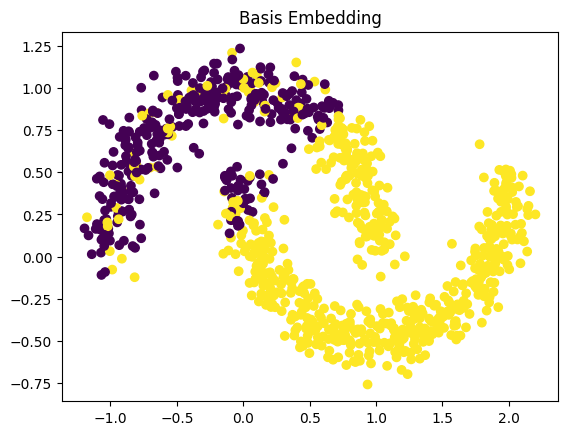

In [58]:
plt.scatter(X[:, 0], X[:, 1], c=test_pred_q3[:, 0].detach().numpy(), cmap='viridis')
plt.title("Basis Embedding")
print(fig.get_size_inches())
Basis_embedding_points_for_1_coordinate_X = []
Basis_embedding_points_for_1_coordinate_Y = []
Basis_embedding_points_for_2_coordinate_X = []
Basis_embedding_points_for_2_coordinate_Y = []

temp = test_pred_q3[:, 0].detach().numpy()
for i in range(0,len(temp -1)):
    if temp[i] == 1:
        Basis_embedding_points_for_1_coordinate_X.append( X[i][0])
        Basis_embedding_points_for_1_coordinate_Y.append( X[i][1])
    elif temp[i] == 0:
        Basis_embedding_points_for_2_coordinate_X.append( X[i][0])
        Basis_embedding_points_for_2_coordinate_Y.append( X[i][1])

Basis_embedding_result = f"{accuracy_fn(y, test_pred_q3):.1f}"

/var/folders/5w/_9ghdxwn44xdbgnr69j2c6wh0000gn/T/ipykernel_1026/3194641380.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1[0,0].scatter( Data_type_1_X, Data_type_1_Y, c='yellow', cmap='viridis')
/var/folders/5w/_9ghdxwn44xdbgnr69j2c6wh0000gn/T/ipykernel_1026/3194641380.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1[0,0].scatter( Data_type_2_X, Data_type_2_Y, c='purple', cmap='viridis')
/var/folders/5w/_9ghdxwn44xdbgnr69j2c6wh0000gn/T/ipykernel_1026/3194641380.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1[0,1].scatter( Angle_embedding_points_for_1_coordinate_X, Angle_embedding_points_for_1_coordinate_Y, c='yellow', cmap='viridis')
/var/folders/5w/_9ghdxwn44xdbgnr69j2c6wh0000gn/T/ipykernel_1026/3194641380.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1[0,1].scatter( Angle_

Text(0.5, 1.0, 'Basis Embedding')

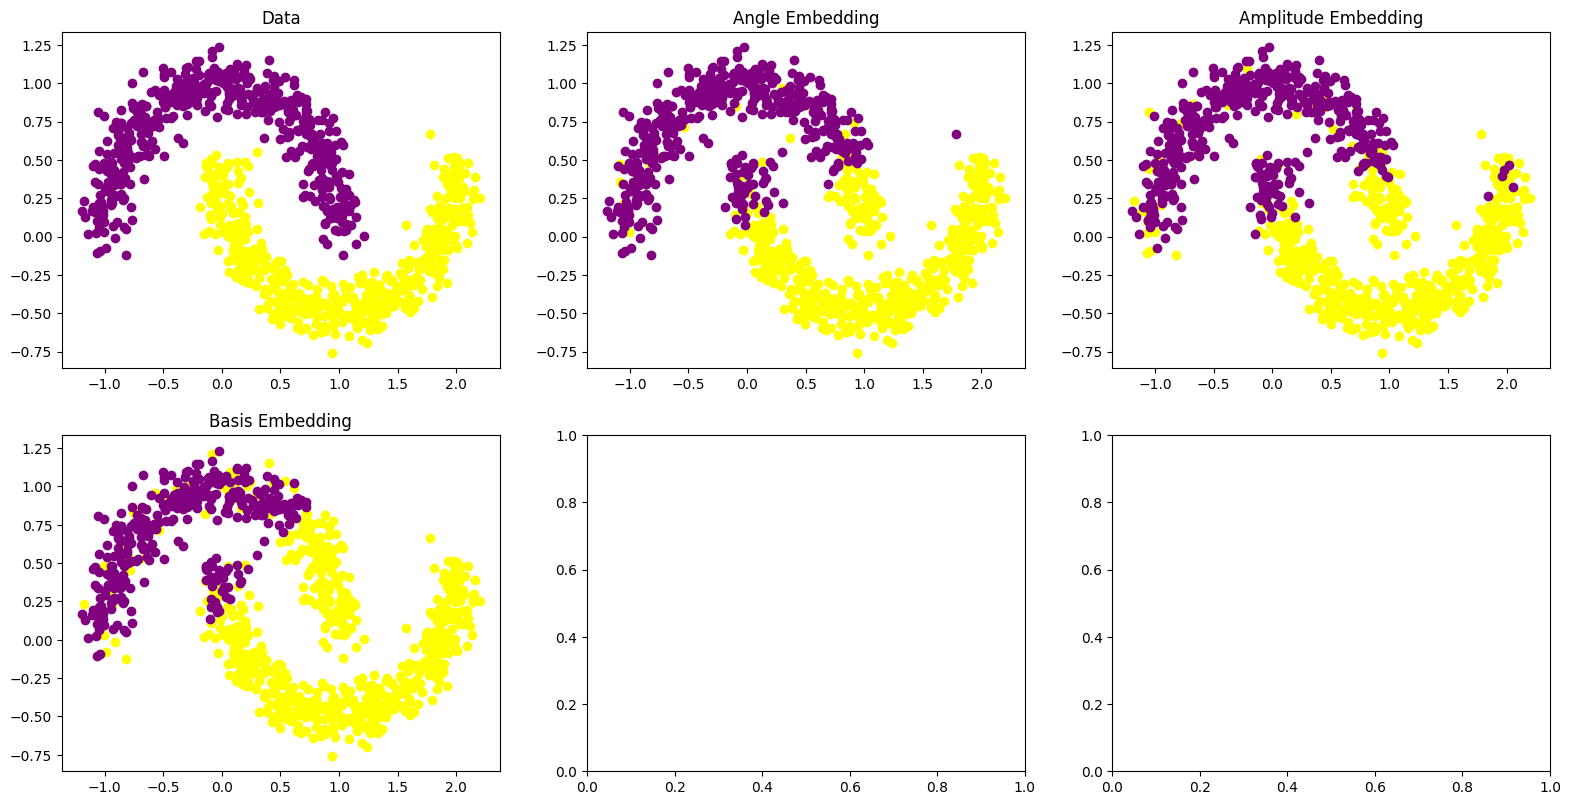

<Figure size 640x480 with 0 Axes>

In [59]:
#compare
fig, ax1 = plt.subplots(2, 3,figsize=(19.2, 9.6)) #9.6, 12.8
fig = plt.figure()
ax1[0,0].scatter( Data_type_1_X, Data_type_1_Y, c='yellow', cmap='viridis')
ax1[0,0].scatter( Data_type_2_X, Data_type_2_Y, c='purple', cmap='viridis')
ax1[0,0].set_title('Data') 
ax1[0,1].scatter( Angle_embedding_points_for_1_coordinate_X, Angle_embedding_points_for_1_coordinate_Y, c='yellow', cmap='viridis')
ax1[0,1].scatter( Angle_embedding_points_for_2_coordinate_X, Angle_embedding_points_for_2_coordinate_Y, c='purple', cmap='viridis')
ax1[0,1].set_title('Angle Embedding')
ax1[0,2].scatter( Amplitude_embedding_points_for_1_coordinate_X, Amplitude_embedding_points_for_1_coordinate_Y, c='yellow', cmap='viridis')
ax1[0,2].scatter( Amplitude_embedding_points_for_2_coordinate_X, Amplitude_embedding_points_for_2_coordinate_Y, c='purple', cmap='viridis')
ax1[0,2].set_title('Amplitude Embedding')
ax1[1,0].scatter( Basis_embedding_points_for_1_coordinate_X, Basis_embedding_points_for_1_coordinate_Y, c='yellow', cmap='viridis')
ax1[1,0].scatter( Basis_embedding_points_for_2_coordinate_X, Basis_embedding_points_for_2_coordinate_Y, c='purple', cmap='viridis')
ax1[1,0].set_title('Basis Embedding')

In [60]:
print("Angle: ", Angle_embedding_result, " %")
print("Amplitude: ", Amplitude_embedding_result, " %" )
print("Basis: ", Basis_embedding_result, " %" )

Angle:  84.8  %
Amplitude:  83.9  %
Basis:  75.8  %
